In [1]:
import os
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import joblib
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import feature_column as fc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import preprocessing
from sklearn.utils import shuffle
from tensorflow.keras.models import save_model,load_model

from utils.util import *
from utils.preprocessing import *
from utils.dataiter import Dataiter
from utils.evaluate import calculate_ctr, compute_rce, average_precision_score
from utils.target_encode import MTE_one_shot

import tensorflow.keras.backend as K
import core.config as conf

## Load data

In [2]:
path = f'{conf.raw_lzo_path}/part-00000'
train = read_data(path)
path = f'{conf.raw_lzo_path}/part-00100'
test = read_data(path)

In [3]:
TARGET = 'like'

- media target encoding(photo, video, gif)
- tweet_type
- language
- tweet_timestamp
- engaged_with_user_id
- engaged_with_user_follower_count
- engaging_user_id
- engaging_user_following_count
- engagee_follows_engager
- 'reply_timestamp', 'retweet_timestamp','retweet_with_comment_timestamp', 'like_timestamp'

## Preprocessing

In [4]:
def set_dataframe_types(df, train):
    df['id']   = np.arange( df.shape[0] )
    df['id']   = df['id'].astype(np.uint32)

    if train:
        df['reply_timestamp']   = df['reply_timestamp'].fillna(0)
        df['retweet_timestamp'] = df['retweet_timestamp'].fillna(0)
        df['comment_timestamp'] = df['comment_timestamp'].fillna(0)
        df['like_timestamp']    = df['like_timestamp'].fillna(0)

        df['reply_timestamp']   = df['reply_timestamp'].astype(np.uint32)
        df['retweet_timestamp'] = df['retweet_timestamp'].astype(np.uint32)
        df['comment_timestamp'] = df['comment_timestamp'].astype(np.uint32)
        df['like_timestamp']    = df['like_timestamp'].astype(np.uint32)

    df['tweet_timestamp']         = df['tweet_timestamp'].astype( np.uint32 )
    df['creator_follower_count']  = df['creator_follower_count'].astype( np.uint32 )
    df['creator_following_count'] = df['creator_following_count'].astype( np.uint32 )
    df['creator_account_creation']= df['creator_account_creation'].astype( np.uint32 )
    df['engager_follower_count']  = df['engager_follower_count'].astype( np.uint32 )
    df['engager_following_count'] = df['engager_following_count'].astype( np.uint32 )
    df['engager_account_creation']= df['engager_account_creation'].astype( np.uint32 )

    return df


def preprocess(df, target, train):
    df = set_dataframe_types(df, train)
    # df = df.set_index('id')
    # df.columns = conf.raw_features + conf.labels
    df = df.drop('text_tokens', axis=1)
    
    df = feature_extraction(df, features=conf.used_features, train=train) # extract 'used_features'
    cols = []

    return df

In [5]:

train = preprocess(train, TARGET, True)


In [6]:
test = preprocess(test, TARGET, True)

### Negative Sampling

In [7]:
df_positive = train[train['like']==1]
df_negative = train[train['like']==0]
print(len(df_positive))
print(len(df_negative))

1207588
1826314


In [8]:
df_negative = df_negative.sample(n = len(df_positive), random_state=777)

In [9]:
train = pd.concat([df_positive, df_negative])

In [10]:
train  = train.sample(frac = 1)

In [11]:
train.head()

,language,domains,engager_account_creation,creator_account_creation,creator_following_count,tweet_id,tweet_timestamp,creator_follows_engager,creator_is_verified,tweet_type,...,engager_id,creator_follower_count,reply,retweet,comment,like,dt_day,dt_dow,dt_hour,len_domains
840103,36,0,1486404542,1596372711,195,E68B6B9D6C8468A51296B9A386C86D4E,1614063446,1,0,1,...,1F9BE8BDED205F915510B2FFCD66B443,180,0.0,0.0,0.0,0.0,23,1,6,0
2521412,61,2712,1324462976,1280204751,2805,D9ADC06364750B255340D9C3A1C3AF3B,1612575857,1,0,2,...,991C4831DB837F645045A0607746BAA5,3605,0.0,0.0,0.0,0.0,6,5,1,1
1720505,41,0,1440703501,1586883676,3116,10F92F1825C682B8F956C1EB5A4A7F1A,1613055954,1,0,2,...,8F721DEDF189B7CFD8E44CADEDA0EF0F,3207,0.0,0.0,0.0,0.0,11,3,15,0
61393,46,0,1541684874,1584008712,961,47C41151C235B158751E3C54712EA2F5,1614109485,1,0,2,...,155FEFD15B42F3738EFE7C5EAA90F00E,1142,0.0,1.0,0.0,0.0,23,1,19,0
115225,62,0,1488035989,1555892357,1024,68FD12BB2B2357E35F31A81303846BC2,1613258501,1,0,1,...,AE3EB92C12A0F6F83DE1C65093ADA587,4127,0.0,0.0,0.0,0.0,13,5,23,0


## Modeling

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2415176 entries, 840103 to 1234581
Data columns (total 25 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   language                  uint8  
 1   domains                   int32  
 2   engager_account_creation  int32  
 3   creator_account_creation  int32  
 4   creator_following_count   int32  
 5   tweet_id                  object 
 6   tweet_timestamp           int32  
 7   creator_follows_engager   int8   
 8   creator_is_verified       int8   
 9   tweet_type                uint8  
 10  creator_id                object 
 11  engager_follower_count    int32  
 12  engager_following_count   int32  
 13  media                     uint8  
 14  engager_is_verified       int8   
 15  engager_id                object 
 16  creator_follower_count    int32  
 17  reply                     float32
 18  retweet                   float32
 19  comment                   float32
 20  like               

In [13]:
label_names = ['reply', 'retweet', 'comment']
DONT_USE = ['engager_account_creation','engage_time',
            'engager_account_creation',
            'fold','tweet_id', 
            'tr','dt_day','','',
            'engager_id','engager_is_verified',
            'elapsed_time',
            'links','domains','hashtags0','hashtags1',
            'hashtags','tweet_hash','dt_second','id',
            'tw_hash0',
            'tw_hash1',
            'tw_rt_uhash',
            'same_language', 'nan_language',
            'tw_hash', 'tw_freq_hash','tw_first_word', 'tw_second_word', 'tw_last_word', 'tw_llast_word',
            'ypred','creator_count_combined','creator_user_fer_count_delta_time','creator_user_fing_count_delta_time','creator_user_fering_count_delta_time','creator_user_fing_count_mode','creator_user_fer_count_mode','creator_user_fering_count_mode'
           ]
DONT_USE += label_names
DONT_USE += conf.labels


In [14]:
RMV = [c for c in DONT_USE if c in train.columns]

### Data Split

In [15]:
#y_train = train[TARGET]
train = train.drop(RMV, axis=1)

In [16]:
train, val = train_test_split(train, test_size=0.2)

In [17]:
test = test.drop(RMV, axis=1)

### Scaling

In [18]:
columns = ['tweet_timestamp', 'creator_account_creation', 'engager_follower_count', 'engager_following_count', 'creator_follower_count', 'creator_following_count']

In [19]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
val = val.reset_index(drop=True)

In [20]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(train[columns])

StandardScaler()

In [21]:
ss = standard_scaler.transform(train[columns])

In [22]:
std_std = pd.DataFrame(ss, columns=columns)

In [23]:
train[columns] = std_std

In [24]:
ss = standard_scaler.transform(val[columns])
std_val = pd.DataFrame(ss, columns = columns)

In [25]:
val[columns] = std_val

In [26]:
ss = standard_scaler.transform(test[columns])
std_test = pd.DataFrame(ss, columns = columns)

In [27]:
test[columns] = std_test

In [28]:
train

,language,creator_account_creation,creator_following_count,tweet_timestamp,creator_follows_engager,creator_is_verified,tweet_type,creator_id,engager_follower_count,engager_following_count,media,creator_follower_count,like,dt_dow,dt_hour,len_domains
0,10,-0.819904,-0.004857,0.533447,1,0,1,15F44F223CAEF58E6422303C2F1AE6C5,-0.046760,-0.283809,5,-0.165509,0.0,2,18,0
1,19,-0.046149,-0.098361,1.711336,1,0,1,53A46339C2898D2280F892DAEE7734C2,-0.020778,0.062282,0,-0.166813,0.0,2,21,0
2,19,-1.367373,-0.109526,0.572595,0,0,2,1060472A90305324E68972423297CD55,-0.048934,-0.125349,0,-0.152662,0.0,2,23,0
3,10,0.466522,-0.094524,0.385024,0,0,1,0368E87152A9489946235DB12718D649,-0.080091,-0.430997,9,-0.165348,1.0,1,20,0
4,41,0.778799,-0.102758,0.651639,1,0,2,4D8C28569248FA4F53CFBABF83B3AA52,-0.067773,-0.396520,0,-0.166806,1.0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1932135,46,-1.290306,-0.081831,-0.605710,0,1,0,A7913C906C695518E7574DCEB72AE967,-0.052764,0.336768,0,-0.156844,0.0,2,20,0
1932136,10,0.472857,-0.103912,0.073950,0,0,2,86133EADAFCA4DB3F490ACFF6AED703B,-0.080920,-0.421052,9,-0.134665,0.0,6,23,0
1932137,47,-0.577101,-0.101199,-0.487242,1,0,2,5FADFB53EB4D6223307A6B616F42438B,-0.044690,-0.216845,0,-0.166719,0.0,3,13,0
1932138,5,-0.195090,-0.035547,0.123081,1,0,2,F36ED0E4DCA7219249DC9A27A02678C0,-0.079988,-0.454202,0,-0.166334,1.0,0,6,0


### Model

In [29]:
def get_quantile_based_boundaries(feature_values, num_buckets):
    boundaries = np.arange(1.0, num_buckets) / num_buckets
    quantiles = feature_values.quantile(boundaries)
    return sorted([quantiles[q] for q in quantiles.keys()])

In [30]:
def construct_feature_columns():
    feature_columns = [] # 변형 데이터???
    feature_layer_inputs={} # 원본 input 데이터????
    
    creator_follower_count = tf.feature_column.numeric_column("creator_follower_count")
    creator_account_creation = tf.feature_column.numeric_column("creator_account_creation")
    language = tf.feature_column.numeric_column("language")
    tweet_type = tf.feature_column.numeric_column("tweet_type")
    media = tf.feature_column.numeric_column("media")
    creator_is_verified = tf.feature_column.numeric_column("creator_is_verified")
    creator_follows_engager = tf.feature_column.numeric_column("creator_follows_engager")
    
    for header in ['language', 'creator_account_creation', 'creator_following_count', 'creator_follower_count', 'engager_following_count', 
                   'engager_follower_count', 'media', 'tweet_type', 'creator_is_verified', 'creator_follows_engager', 'dt_dow', 'dt_hour', 'len_domains']:
        feature_columns.append(tf.feature_column.numeric_column(header))
        feature_layer_inputs[header] = tf.keras.Input(shape=(1,), name=header)
    
    # creator_id = tf.feature_column.embedding_column('creator_id', dimension=8)

    bucketized_creator_follower_count = tf.feature_column.bucketized_column(
        creator_follower_count, boundaries=get_quantile_based_boundaries(
            train["creator_follower_count"], 10))
    feature_columns.append(bucketized_creator_follower_count)
    
    bucketized_creator_account_creation = tf.feature_column.bucketized_column(
        creator_account_creation, boundaries=get_quantile_based_boundaries(
            train["creator_account_creation"], 10))
    feature_columns.append(bucketized_creator_account_creation)
    
    creator_follower_x_account = tf.feature_column.crossed_column(
        set([bucketized_creator_follower_count, bucketized_creator_account_creation]), hash_bucket_size=1000)
    creator_follower_x_account = tf.feature_column.indicator_column(creator_follower_x_account)
    feature_columns.append(creator_follower_x_account)
    
    language_x_tweet_type_x_media = tf.feature_column.crossed_column(
        set(["language", "tweet_type", "media"]), hash_bucket_size=10000)
    language_x_tweet_type_x_media = tf.feature_column.indicator_column(language_x_tweet_type_x_media)
    feature_columns.append(language_x_tweet_type_x_media)
    
    language_x_tweet_type = tf.feature_column.crossed_column(
        set(["language", "tweet_type"]), hash_bucket_size=1000)
    language_x_tweet_type = tf.feature_column.indicator_column(language_x_tweet_type)
    feature_columns.append(language_x_tweet_type)
    
    language_x_media = tf.feature_column.crossed_column(
        set(["language", "media"]), hash_bucket_size=1000)
    language_x_media = tf.feature_column.indicator_column(language_x_media)
    feature_columns.append(language_x_media)
    
    language_x_media_x_tweet_type_x_creator_is_verified_x_creator_follows_engager = tf.feature_column.crossed_column(
        set(["language", "media", "tweet_type", "creator_is_verified", 'creator_follows_engager']), hash_bucket_size=10000)
    language_x_media_x_tweet_type_x_creator_is_verified_x_creator_follows_engager = tf.feature_column.indicator_column(language_x_media_x_tweet_type_x_creator_is_verified_x_creator_follows_engager)
    feature_columns.append(language_x_media_x_tweet_type_x_creator_is_verified_x_creator_follows_engager)
    
    
    #feature_layer_inputs['bucketized_creator_account_creation'] = tf.keras.Input(shape=(1,), name='bucketized_creator_account_creation')

    #feature_layer_inputs['creator_follower_x_account'] = tf.keras.Input(shape=(1,), name='creator_follower_x_account')
    
    return feature_columns, feature_layer_inputs

In [31]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('like')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size, drop_remainder=True)
    return ds

In [32]:
ds_train = df_to_dataset(train)
ds_val = df_to_dataset(val, shuffle=False)
ds_test = df_to_dataset(test, shuffle=False)

In [33]:
feature_columns, feature_layer_inputs = construct_feature_columns()

In [34]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [35]:
feature_layer_output = feature_layer(feature_layer_inputs)

In [36]:
input = [v for v in feature_layer_inputs.values()]

In [37]:
x = Dense(16, activation="relu")(feature_layer_output)
x = Dense(8, activation="relu")(x)
x = Dense(4, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)

In [38]:
model = tf.keras.Model(inputs=input, outputs=outputs, name="sequential_model")

In [39]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy', # softmax : sparse_categorical_crossentropy, sigmoid : binary_crossentropy
    metrics=['binary_crossentropy']) # sigmoid :binary_crossentropy

In [40]:
ds_train

<BatchDataset shapes: ({language: (32,), creator_account_creation: (32,), creator_following_count: (32,), tweet_timestamp: (32,), creator_follows_engager: (32,), creator_is_verified: (32,), tweet_type: (32,), creator_id: (32,), engager_follower_count: (32,), engager_following_count: (32,), media: (32,), creator_follower_count: (32,), dt_dow: (32,), dt_hour: (32,), len_domains: (32,)}, (32,)), types: ({language: tf.uint8, creator_account_creation: tf.float64, creator_following_count: tf.float64, tweet_timestamp: tf.float64, creator_follows_engager: tf.int8, creator_is_verified: tf.int8, tweet_type: tf.uint8, creator_id: tf.string, engager_follower_count: tf.float64, engager_following_count: tf.float64, media: tf.uint8, creator_follower_count: tf.float64, dt_dow: tf.int8, dt_hour: tf.int8, len_domains: tf.int64}, tf.float32)>

In [41]:
model.summary()

Model: "sequential_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
creator_account_creation (Input [(None, 1)]          0                                            
__________________________________________________________________________________________________
creator_follower_count (InputLa [(None, 1)]          0                                            
__________________________________________________________________________________________________
creator_following_count (InputL [(None, 1)]          0                                            
__________________________________________________________________________________________________
creator_follows_engager (InputL [(None, 1)]          0                                            
___________________________________________________________________________________

In [42]:
ds_train

<BatchDataset shapes: ({language: (32,), creator_account_creation: (32,), creator_following_count: (32,), tweet_timestamp: (32,), creator_follows_engager: (32,), creator_is_verified: (32,), tweet_type: (32,), creator_id: (32,), engager_follower_count: (32,), engager_following_count: (32,), media: (32,), creator_follower_count: (32,), dt_dow: (32,), dt_hour: (32,), len_domains: (32,)}, (32,)), types: ({language: tf.uint8, creator_account_creation: tf.float64, creator_following_count: tf.float64, tweet_timestamp: tf.float64, creator_follows_engager: tf.int8, creator_is_verified: tf.int8, tweet_type: tf.uint8, creator_id: tf.string, engager_follower_count: tf.float64, engager_following_count: tf.float64, media: tf.uint8, creator_follower_count: tf.float64, dt_dow: tf.int8, dt_hour: tf.int8, len_domains: tf.int64}, tf.float32)>

In [43]:
history = model.fit(ds_train, epochs=5)

Epoch 1/5


/home/nyongja/anaconda3/envs/dask/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['tweet_timestamp', 'creator_id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


60379/60379 [==============================] - 103s 2ms/step - loss: 0.6472 - binary_crossentropy: 0.6472
Epoch 2/5
60379/60379 [==============================] - 97s 2ms/step - loss: 0.6380 - binary_crossentropy: 0.6380
Epoch 3/5
60379/60379 [==============================] - 109s 2ms/step - loss: 0.6366 - binary_crossentropy: 0.6366
Epoch 4/5
60379/60379 [==============================] - 121s 2ms/step - loss: 0.6356 - binary_crossentropy: 0.6356
Epoch 5/5
60379/60379 [==============================] - 118s 2ms/step - loss: 0.6351 - binary_crossentropy: 0.6351


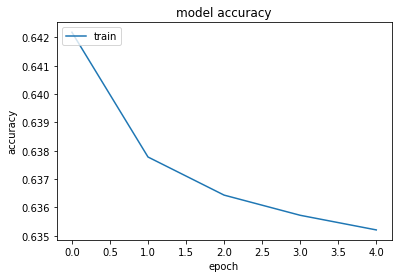

In [46]:
plt.plot(history.history['binary_crossentropy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [47]:
model.evaluate(ds_test)

94767/94767 [==============================] - 100s 1ms/step - loss: 0.6537 - binary_crossentropy: 0.6537


[0.6536824107170105, 0.6536824107170105]

## Predict

In [51]:
y = np.concatenate([y for x, y in ds_test], axis=0)

In [48]:
pred = model.predict(ds_test)

In [67]:
pred = pred.astype(np.float64)

In [68]:
rce = compute_rce(pred, y)
rce

2.756002592739626

In [53]:
average_precision_score(y, pred)

0.539318548018725

In [51]:
model.summary()

Model: "sequential_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
creator_account_creation (Input [(None, 1)]          0                                            
__________________________________________________________________________________________________
creator_follower_count (InputLa [(None, 1)]          0                                            
__________________________________________________________________________________________________
creator_following_count (InputL [(None, 1)]          0                                            
__________________________________________________________________________________________________
creator_follows_engager (InputL [(None, 1)]          0                                            
___________________________________________________________________________________

In [52]:
model_path = f'/hdd/cpu_models_DNN/model-ffnn.h5'
            
save_model(model, model_path)